<a href="https://colab.research.google.com/github/milijan/market/blob/main/keras/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

plt.style.use('fivethirtyeight')

In [3]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-11-21' )
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.566676
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.634213
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.774481
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.908023
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,12.887549
...,...,...,...,...,...,...
2020-11-16,120.989998,118.150002,118.919998,120.300003,91183000.0,120.300003
2020-11-17,120.669998,118.959999,119.550003,119.389999,74271000.0,119.389999
2020-11-18,119.820000,118.000000,118.610001,118.029999,76322100.0,118.029999


Text(0, 0.5, 'USD')

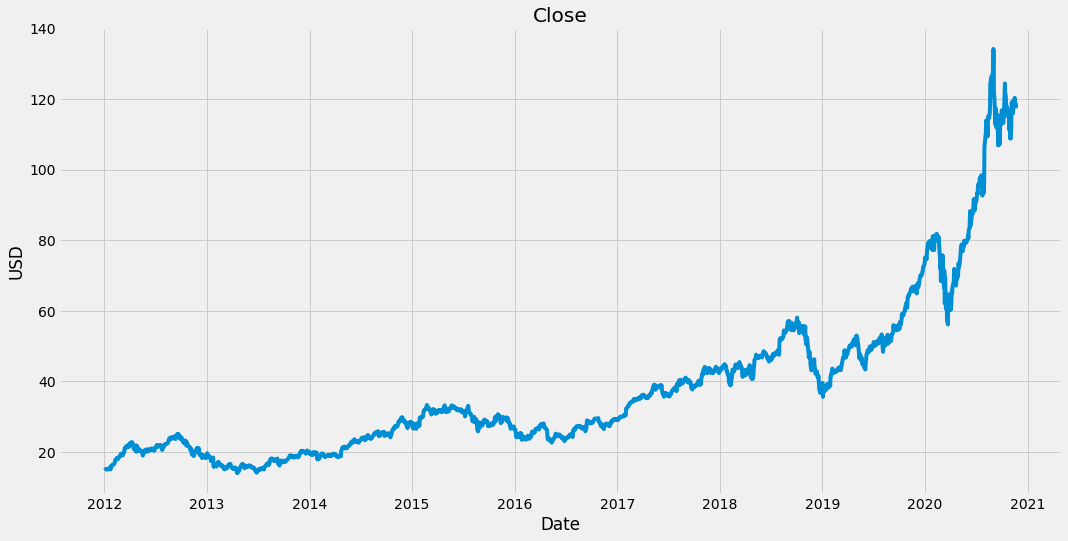

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('USD')

In [5]:
close_df = df.filter(['Close'])
close_data = close_df.values
training_data_len = math.ceil(len(close_data) * 0.8)
training_data_len

1791

In [6]:
normaliser = MinMaxScaler(feature_range=(0,1))
close_normalised = normaliser.fit_transform(close_data)

close_normalised.shape


(2238, 1)

In [7]:
training_data = close_normalised[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(training_data)):
  x_train.append(training_data[i-60:i, 0])
  y_train.append(training_data[i, 0])
  if i <= 60:
    print(x_train)
    print(y_train)


[array([0.0061488 , 0.00680527, 0.00816869, 0.00946678, 0.00926776,
       0.00971629, 0.00951133, 0.00916676, 0.00869744, 0.01014998,
       0.01145994, 0.01105596, 0.00884299, 0.01095496, 0.00887566,
       0.01667305, 0.01607005, 0.01685722, 0.01855928, 0.01959001,
       0.01950387, 0.01918604, 0.02054056, 0.02181487, 0.02325851,
       0.0255903 , 0.03048855, 0.03056281, 0.03328967, 0.03532738,
       0.03182524, 0.03317382, 0.03314709, 0.03692846, 0.0363908 ,
       0.03738589, 0.0391741 , 0.0401692 , 0.04303567, 0.04512389,
       0.04572687, 0.04593778, 0.04236733, 0.04150589, 0.04163362,
       0.04499021, 0.04593482, 0.04796361, 0.05274602, 0.05912652,
       0.0579324 , 0.05793537, 0.06254846, 0.06399208, 0.06296431,
       0.06202567, 0.06104839, 0.06429507, 0.06652291, 0.06745562])]
[0.06515055661523342]


In [28]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape 

(1731, 60, 1)

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1731/1731 [==============================] - 33s 19ms/step - loss: 2.8465e-04


In [18]:
test_data = close_normalised[training_data_len - 60:, :]
x_test = []
y_test = close_data[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [20]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [31]:
predictions = model.predict(x_test)
predictions = normaliser.inverse_transform(predictions)
rmse = np.sqrt(np.mean( (predictions - y_test)**2 ))
rmse

4.744286638606192

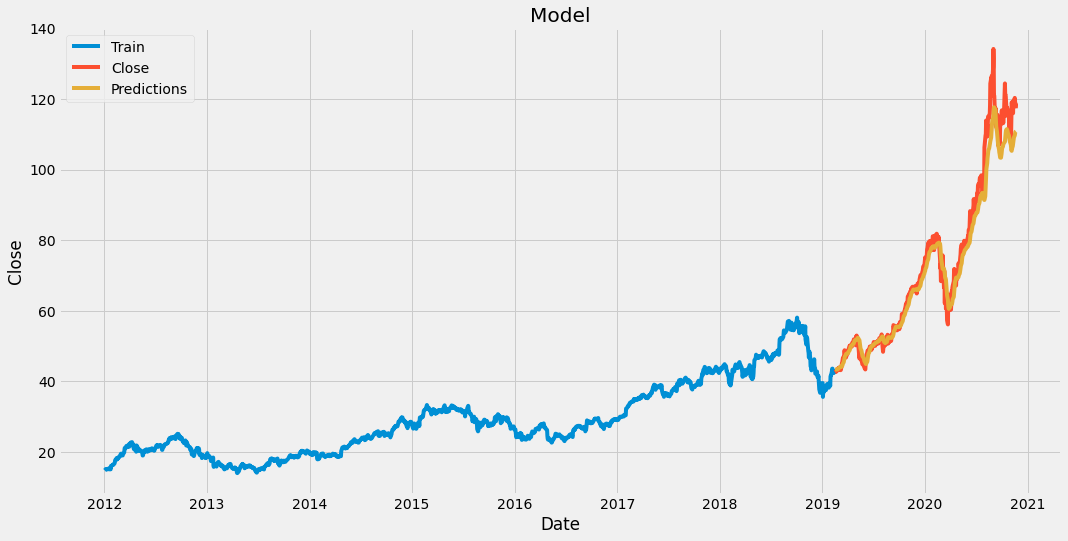

In [44]:
close_train = close_df[:training_data_len].copy()
close_valid = close_df[training_data_len:].copy()
close_valid.shape
close_valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(close_train['Close'])
plt.plot(close_valid[['Close', 'Predictions']])
plt.legend(['Train', 'Close' ,'Predictions'])

In [46]:
close_valid

,Close,Predictions
Date,,
2019-02-15,42.605000,43.297760
2019-02-19,42.732498,43.294956
2019-02-20,43.007500,43.287525
2019-02-21,42.764999,43.304142
2019-02-22,43.242500,43.309578
...,...,...
2020-11-16,120.300003,109.657867
2020-11-17,119.389999,110.214355
2020-11-18,118.029999,110.614342


In [52]:
df_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-11-21' )
df_quote_close = df_quote.filter(['Close'])
last_60days = df_quote_close[-60:].values
last_60days_norm = normaliser.transform(last_60days)
x_test = []
x_test.append(last_60days_norm)
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = model.predict(x_test)
pred_price = normaliser.inverse_transform(pred_price)

pred_price


array([[110.715805]], dtype=float32)